In [5]:
import os
import torch
import matplotlib.pylab as plt
import numpy as np
import traceback
from torch.utils.data import Dataset, DataLoader
import torchnet.meter.confusionmeter as cm
import seaborn as sn

torch.manual_seed(0)
import pandas as pd

from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from matplotlib import pyplot as plt

plt.style.use("ggplot")
import seaborn as sns
from PIL import Image
import pandas as pd
import os

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score

cudnn.benchmark = True
plt.ion()  # interactive mode

os.chdir("C://Users//vnarv//PycharmProjects/pytorch_classification")

In [2]:
# conda install freetype

In [3]:
os.getcwd()

'C:\\Users\\vnarv\\PycharmProjects\\pytorch_classification\\notebooks'

In [6]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "data/garbage_classification"

train_dataset = datasets.ImageFolder(
    os.path.join(data_dir, "train"), data_transforms["train"]
)
train_data, val_data = train_test_split(train_dataset, test_size=0.2, random_state=42)

image_datasets = {
    "train": train_data,
    "val": val_data,
    "test": datasets.ImageFolder(
        os.path.join(data_dir, "test"), data_transforms["test"]
    ),
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=100, shuffle=True, num_workers=4
    )
    for x in ["train", "val", "test"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}
class_names = ["Carton", "Métal", "Plastique", "Verre"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1ec43e734f0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1ec43e73100>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1ec45306820>}

Class weights: assign a higher weight to the minority class samples to give more importance to these samples in the training process

In [10]:
# change weights
def compute_weights(labels):
    n_samples = len(labels)
    label_counts = Counter(labels)
    print(label_counts)
    class_weights = [
        n_samples / (label_counts[i] * len(label_counts))
        for i in range(len(label_counts))
    ]
    return class_weights


def imshow(inp, title=None, normalize=True):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


def train_model(model, criterion, optimizer, scheduler, alias, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    # accuracy
    # best_acc = 0.0
    # F1 score
    best_F1_score = 0.0
    f1_train_score_epoch = []
    f1_val_score_epoch = []
    # keeping-track-of-losses
    train_losses = []
    valid_losses = []
    # stop training if loss doesnt imrpove for 5 consecutif epochs
    early_stopping_epochs = 5
    # Keep track of the number of epochs without improvement
    no_improvement_epochs = 0
    flag = False
    # start training
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
            # set training and validation loss equal to 0
            running_loss = 0.0
            running_f1 = 0.0
            total_f1 = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # input to the f1 score must be array, not tensor
                f1 = f1_score(
                    labels.cpu().numpy(), preds.cpu().numpy(), average="macro"
                )
                # weight score by sample size in the batch
                running_f1 += f1 * inputs.size(0)
                total_f1 += f1
            # the learning rate is only updated during the training phase
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1 = running_f1 / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.2f} F1 score: {epoch_f1:.2f}")
            if phase == "train":
                f1_train_score_epoch.append(epoch_f1)
                train_losses.append(epoch_loss)
            else:
                f1_val_score_epoch.append(epoch_f1)
                valid_losses.append(epoch_loss)

            # deep copy the model
            if phase == "val" and epoch_f1 > best_F1_score:
                best_F1_score = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
                no_improvement_epochs = 0
            elif phase == "val" and epoch_f1 <= best_F1_score:
                no_improvement_epochs += 1
            else:
                print()

            # If the performance has not improved for early_stopping_epochs, stop training
            if no_improvement_epochs >= early_stopping_epochs:
                print(no_improvement_epochs)
                print(early_stopping_epochs)
                print("Early stopping after epoch", epoch)
                flag = True
                break
        if flag:
            break
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best F1 score: {best_F1_score:4f}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    # store losses and F1 score
    data = {
        "train_losses": train_losses,
        "val_losses": valid_losses,
        "f1_train_score_epoch": f1_train_score_epoch,
        "f1_val_score_epoch": f1_val_score_epoch,
    }
    df_summary = pd.DataFrame(data)
    df_summary.to_csv(f"summary_{alias}.csv", sep=";")

    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            ls_labels = labels.tolist()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(
                    f"predicted: {class_names[preds[j]]}, true label: {class_names[ls_labels[j]]}"
                )
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)


def visualize_wrong_labels(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if labels[j].item() != preds[j].item():
                    images_so_far += 1
                    if images_so_far > num_images:
                        model.train(mode=was_training)
                        return
                    ax = plt.subplot(4, 4, images_so_far)
                    ax.axis("off")
                    ax.set_title(
                        f"True: {class_names[labels[j].item()]} / Predicted: {class_names[preds[j].item()]}",
                        fontsize=9,
                    )
                    # imshow(inputs.cpu().data[j], normalize=True)
                    inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    inp = std * inp + mean
                    inp = np.clip(inp, 0, 1)
                    plt.imshow(inp)
        model.train(mode=was_training)

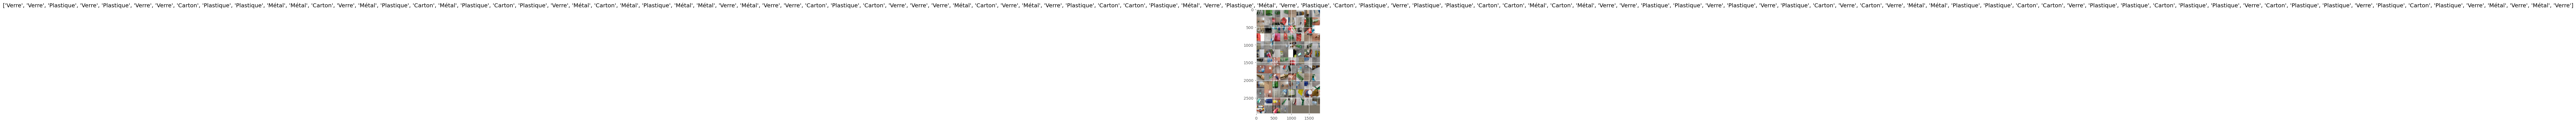

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

## Evaluate the model

In [10]:
def plot_model(train_loss, val_loss, epoch, title, y_label):
    plt.style.use("ggplot")
    sns.lineplot(x=np.arange(len(train_loss)), y=train_loss, label="train")
    sns.lineplot(x=np.arange(len(val_loss)), y=val_loss, label="validation")
    plt.xlabel("epoch")
    plt.ylabel(y_label)
    plt.title(title)
    plt.xlim(0, len(train_loss))
    plt.show()

In [11]:
def make_prediction(dataloader=dataloaders["val"]):
    with torch.no_grad():
        y_true = []
        y_pred = []
        for i, (inputs, labels) in enumerate(dataloader):  # change to test if needed
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
    return y_true, y_pred

In [12]:
def compute_overall_metrics(y_true, y_pred):
    # macro option is used here bcs we care about each class equally
    model_f1 = f1_score(y_true, y_pred, average="macro")
    model_recall = recall_score(y_true, y_pred, average="macro")
    model_precision = precision_score(y_true, y_pred, average="macro")
    print("Overall F1 score of the network is: %d %%" % (100 * model_f1))
    print("Overall weighted recall score is: %d %%" % (100 * model_recall))
    print("Overall weighted precison score is: %d %%" % (100 * model_precision))

In [13]:
def compute_class_wise_stats(dataloader=dataloaders["val"]):
    # Class wise statistics
    FP = list(0.0 for i in range(4))
    TP_FN = list(0.0 for i in range(4))
    TP = list(0.0 for i in range(4))
    try:
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(dataloader):
                inputs = inputs.to(device)
                # true labels
                labels = labels.to(device)
                # predicted labels
                outputs = model_ft(inputs)
                _, predicted = torch.max(outputs, 1)
                # keep only if predicted classe equals true class
                point = (predicted == labels).squeeze()
                for j in range(len(labels)):
                    label = labels[j]
                    # keep track of the true positifs
                    if len(point) > 0:
                        TP[label] += point[j].item()
                    else:
                        TP[label] += point
                    # keep track of all the true labels for a class
                    TP_FN[label] += 1
                    if predicted[j] != label:
                        FP[predicted[j]] += 1
    except Exception as e:
        print(e)
    # compute recall and precision per class
    recall_all = []
    precision_all = []
    for i in range(4):
        recall = TP[i] / TP_FN[i]
        precision = TP[i] / (TP[i] + FP[i])

        print("Recall of %5s : %2d %%" % (class_names[i], 100 * recall))
        recall_all.append(recall)
        print("Precision of %5s : %2d %%" % (class_names[i], 100 * precision))
        precision_all.append(precision)
    return recall_all, precision_all


def compute_confusion_mtx(dataloader=dataloaders["val"]):
    # Get the confusion matrix for testing data
    confusion_matrix = cm.ConfusionMeter(4)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            confusion_matrix.add(predicted, labels)

    # Confusion matrix as a heatmap
    con_m = confusion_matrix.conf
    df_con_m = pd.DataFrame(
        con_m, index=[i for i in class_names], columns=[i for i in class_names]
    )
    sns.set(font_scale=1.5)
    sns.heatmap(
        df_con_m, annot=True, fmt="g", annot_kws={"size": 10}, cbar=False, cmap="Greens"
    )
    plt.xlabel("Predicted values")
    plt.ylabel("True labels")
    plt.show()

## Freezed model training

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.


In [14]:
print("Train dataset size:", dataset_sizes["train"])  # dataset_sizes
print("Validation dataset size:", dataset_sizes["val"])
print("Test dataset size:", dataset_sizes["test"])
print("Classe: ", class_names)

Train dataset size: 1229
Validation dataset size: 308
Test dataset size: 384
Classe:  ['Carton', 'Métal', 'Plastique', 'Verre']


In [1]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
# model_conv.fc = nn.Linear(num_ftrs, 4)
model_conv.fc = nn.Sequential(
    nn.Linear(num_ftrs, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 4),
)

# dropout layer
model_conv.fc = nn.Sequential(nn.Dropout(p=0.2), model_conv.fc)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(
    model_conv.fc.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001
)
# optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.01, weight_decay=0.001)

# Decay LR by a factor of 0.1 every 7 epochs, adjusts learning rate
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.01)

NameError: name 'torchvision' is not defined

In [ ]:
model_conv = train_model(
    model_conv,
    criterion,
    optimizer_conv,
    exp_lr_scheduler,
    num_epochs=25,
    alias="freezed_network_gamma_01",
)

In [ ]:
# save model
# torch.save(model_conv, "freezed_network_gamma_01.pt")

In [17]:
# load model
model_ft = torch.load("notebooks/freezed_network_gamma_01.pt")
# model_ft = torch.load("tf_batchnorm_100_regul.pt")

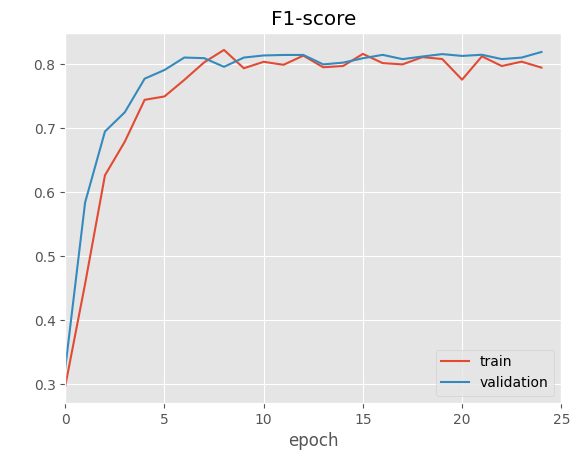

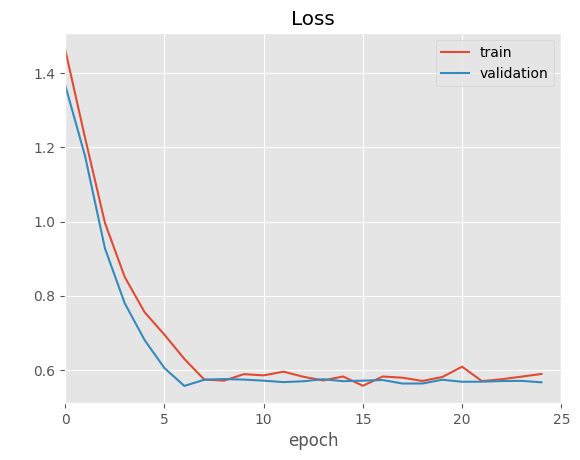

In [15]:
df = pd.read_csv("summary_freezed_network_gamma_01.csv", sep=";")
plot_model(
    df["f1_train_score_epoch"],
    df["f1_val_score_epoch"],
    len(df["f1_train_score_epoch"]),
    "F1-score",
    " ",
)
plot_model(df["train_losses"], df["val_losses"], len(df["train_losses"]), "Loss", " ")

Overall F1 score of the network is: 87 %
Overall weighted recall score is: 88 %
Overall weighted precison score is: 87 %
Recall of Carton : 94 %
Precision of Carton : 82 %
Recall of Métal : 91 %
Precision of Métal : 86 %
Recall of Plastique : 82 %
Precision of Plastique : 92 %
Recall of Verre : 86 %
Precision of Verre : 86 %


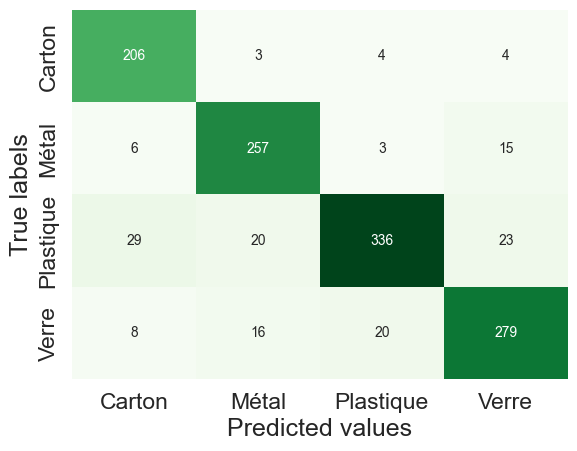

In [16]:
### statistics for the train set
train_true, train_pred = make_prediction(dataloaders["train"])
overall_metrics_validation = compute_overall_metrics(train_true, train_pred)
train_recall, train_precision = compute_class_wise_stats(dataloaders["train"])
compute_confusion_mtx(dataloaders["train"])

Overall F1 score of the network is: 79 %
Overall weighted recall score is: 81 %
Overall weighted precison score is: 79 %
Recall of Carton : 91 %
Precision of Carton : 65 %
Recall of Métal : 84 %
Precision of Métal : 79 %
Recall of Plastique : 78 %
Precision of Plastique : 86 %
Recall of Verre : 70 %
Precision of Verre : 84 %


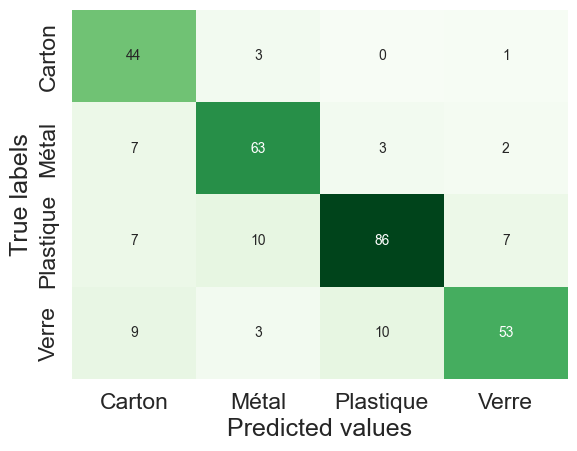

In [17]:
### statistics for the validation set
val_true, val_pred = make_prediction()
overall_metrics_validation = compute_overall_metrics(val_true, val_pred)
val_recall, val_precision = compute_class_wise_stats()
compute_confusion_mtx()

Overall F1 score of the network is: 83 %
Overall weighted recall score is: 83 %
Overall weighted precison score is: 84 %
Recall of Carton : 94 %
Precision of Carton : 80 %
Recall of Métal : 88 %
Precision of Métal : 80 %
Recall of Plastique : 82 %
Precision of Plastique : 84 %
Recall of Verre : 69 %
Precision of Verre : 93 %


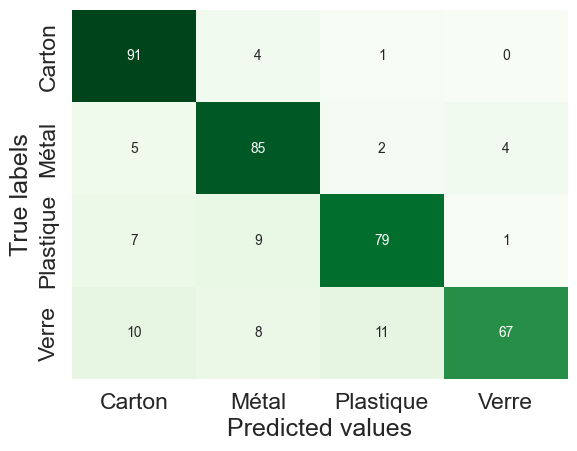

In [18]:
### statistics for the test set
test_true, test_pred = make_prediction(dataloaders["test"])
overall_metrics_validation = compute_overall_metrics(test_true, test_pred)
test_recall, test_precision = compute_class_wise_stats(dataloaders["test"])
compute_confusion_mtx(dataloaders["test"])

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()

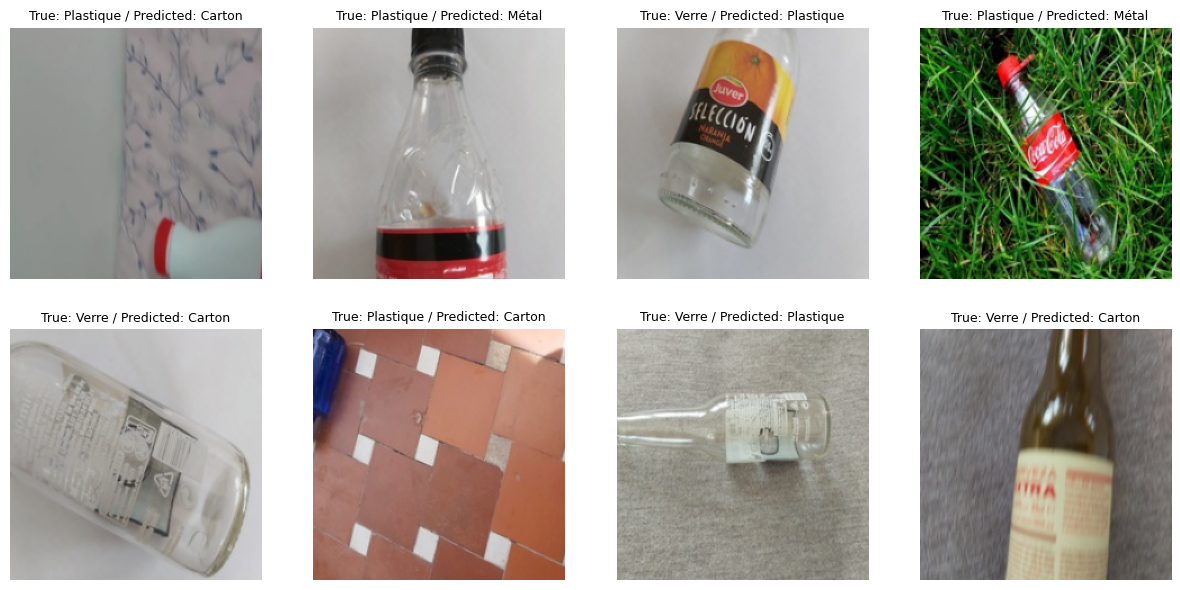

In [21]:
l(model_ft)